<a href="https://colab.research.google.com/github/physicsllama/rl-quantum/blob/main/Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qutip

     |████████████████████████████████| 14.7 MB 437 kB/s 


In [2]:
import numpy as np
import cmath
import random
from gym import Env
from gym.spaces import Discrete, Box, Dict
from qutip import *

# Edit code because don't actually need to do matrix multiplication & translation!
# Possible to work only with bloch sphere parameters throughout whole thing

In [30]:
qubit_eps = 0.05

# Defining parts of the environment to deal with "continuous" variables (angles)
samples = 25
theta = np.linspace(0, np.pi, samples)
phi = np.linspace(0, 2*np.pi, samples)

theta1 = random.choice(theta)
phi1 = random.choice(phi)

theta2 = random.choice(theta)
phi2 = random.choice(phi)

final_qubit = np.array([np.cos(theta2 / 2), np.exp(1j * phi2) * np.sin(theta2 / 2)])

class QubitUnitary(Env):
    def __init__(self):
        #What we can observe: a single qubit, characterized by 2 real numbers. Maybe should list this in some other way?
        self.observation_space = Box(low=np.array([0, 0]), high=np.array([np.pi, 2 * np.pi]), shape = (2,))
        
        #What actions we can take: choose a unitary along an axis (x, y, or z) and a real angle of rotation around that axis.
        #Not sure that the range of angles I've given here is correct!
        #Instead of a dictionary I should try something more compatible with the other things! (like just a box)
        self.action_space = Dict({"axis": Discrete(3), "angle": Box(low = 0, high = 2 * np.pi, shape = (1,))})
        
        #Starting qubit. Should it always be the same? Let's say yes for now, and adjust later if we don't want this.
        #r = random.uniform(0,1)
        #alpha = random.uniform(0, 2*np.pi)
        #beta = random.uniform(0, 2*np.pi)
        self.theta = theta1
        self.phi = phi1
        self.state = np.array([self.theta, self.phi])
        self.qubit = np.array([np.cos(self.theta / 2), np.exp(1j * self.phi) * np.sin(self.theta / 2)])
        
        #Maximum number of unitaries before resetting
        self.max_unitaries = 10

        self.b = Bloch()
    
    def rot(self, axis, angle):
        #if axis = 0, rotate x. if 1, rotate y. if 2, rotate z. Return the unitary matrix corresponding to the rotation with that axis and that angle!
        if axis == 0:
          return np.array([[np.cos(angle / 2), -1j * np.sin(angle / 2)], [-1j * np.sin(angle / 2), np.cos(angle / 2)]])
        elif axis == 1: 
          return np.array([[np.cos(angle / 2), -np.sin(angle / 2)], [np.sin(angle / 2), np.cos(angle / 2)]])
        elif axis == 2:
          return np.array([[np.exp(-1j * angle / 2), 0], [0, np.exp(1j * angle / 2)]])
        else: #maybe just assert instead?
          return None

    def qubit_fidelity(self, qubit1, qubit2):
      return np.dot(qubit1, np.conjugate(qubit2)) * np.dot(np.conjugate(qubit1),qubit2)

    def step(self, action):
        # Change the qubit depending on what action we took
        self.qubit = np.dot(self.rot(action["axis"], action["angle"][0]), self.qubit)

        # Update parameters and state
        self.theta = 2 * np.arccos(np.abs(self.qubit[0])-0.001)
        self.phi = cmath.phase(self.qubit[1])
        self.state = [self.theta, self.phi]

        # Decrease unitaries remaining
        self.max_unitaries -= 1
        
        # Reward step. Use criterion of distance to final qubit.
        if self.qubit_fidelity(self.qubit, final_qubit) > (1 - qubit_eps): #and self.max_unitaries >= 7: #Adjust here!!! Will need to tune and play around. Give reward even if don't arrive right away. Penalize each extra step.
            reward = 10
        else:
            reward = - 1
            
        # Check if we've used up all unitaries:
        if self.qubit_fidelity(self.qubit, final_qubit) > (1-qubit_eps) or self.max_unitaries <= 0:
            done = True
        else:
            done = False
        info = {}

        return self.state, reward, done, info
        
    def render(self):
        self.b = Bloch()
        self.b.vector_color = ['r']
        self.b.view = [-40,30]
        

    def reset(self):
        # Reset qubit to initial state. Maybe will want a random initial state later?
        self.theta = random.choice(theta)
        self.phi = random.choice(phi)
        #self.theta = theta1
        #self.phi = phi1
        self.state = np.array([self.theta, self.phi])
        self.qubit = np.array([np.cos(self.theta / 2), np.exp(1j * self.phi) * np.sin(self.theta / 2)])

        # Reset max number of unitaries
        self.max_unitaries = 10


class QValue():
  def __init__(self):
    self.hello = None

In [31]:
env = QubitUnitary()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# RL Algorithm for Q-Learning

In [32]:
# Q is organized as [theta, phi, angle, axis]
Q_Full = np.zeros((samples **3 * 3,1))
Q_Matrix = np.reshape(Q_Full, (samples,samples,samples,3,1))
# Maybe class is better way to deal with Q_Data or Q_Full!

In [33]:
# Use epsilon-greedy strategy to explore space of possibilities and update Q values for some of the data.
def select_action(s, epsilon):
  p = random.random()
  if p < epsilon:
    return env.action_space.sample()
  else:
    s1 = int( np.floor(samples * s[0] / np.pi) -1 ) # Index associated to s1.
    s2 = int( np.floor(samples * s[1] / (2.0 * np.pi)) -1 )
    # best_index = np.unravel_index(Q_Full[s1][s2].argmax(), Q_Full[s1][s2].shape) # Gives index of correct action in Q given s.
    #Q_Matrix = np.reshape(Q_Full, (samples,samples,samples,3,1))
    best_index = np.unravel_index(Q_Matrix[s1][s2].argmax(), Q_Matrix[s1][s2].shape)
    best_angle = phi[best_index[0]]
    best_axis = best_index[1]
    best_action = {'axis': best_axis, 'angle' : [best_angle]}
    return best_action

# Update Q to obtain new data for training. Use QubitUnitary class here. Careful: states and actions will be INDICES below!
# Sort out -1 in index nonsense below!
def update_Q(s, a, alpha, gamma):
  s1 = int( np.floor(samples * s[0] / np.pi) -1)
  s2 = int( np.floor(samples * s[1] / (2.0 * np.pi))-1 )
  a1 = int( np.floor(samples * a['angle'][0] / (2.0 * np.pi))-1 )
  a2 = a['axis']
  new_s, reward, done, info = env.step(a)
  new_s1 = int( np.floor(samples * new_s[0] / np.pi)  ) -1
  new_s2 = int( np.floor(samples * new_s[1] / (2.0 * np.pi))  ) -1

  Q_Matrix[s1][s2][a1][a2] = (1-alpha) * Q_Matrix[s1][s2][a1][a2] + alpha * (reward + gamma * np.max(Q_Matrix[new_s1][new_s2]))
  # Only append to data if the s, a are not there already. Maybe not necessary as a first approximation though! Will make it less efficient as data grows.
  # Almost certainly do it!
  # Q_Data.append([s[0], s[1], a['angle'][0], a2, Q_Matrix[s1][s2][a1][a2]])
  return done

# Training

In [34]:
warmup_steps = 500000
counter = 0
while warmup_steps > 0:
  env.reset()

  # Now run loop where we get to explore until done! So 10 unitaries essentially. Set reward to be 0 initially.
  Done = False

  while not Done:
    counter += 1
    s = env.state
    action = env.action_space.sample() #select_action(s, 0.99)
    Done = update_Q(s, action, 0.99, 0.8) # Tweak alpha and gamma here! 
  
  warmup_steps -= 1

In [35]:
runs = 10
eps = 0.2
alpha = 0.99
while runs >= 0:

  epochs = 100000
  while epochs >= 0:
    env.reset()
    # Now run loop where we get to explore until done! So 10 unitaries essentially.
    Done = False
    while not Done:
      s = env.state
      action = select_action(s, eps)
      Done = update_Q(s, action, alpha, 0.8) # Tweak alpha and gamma here! 

    epochs -= 1

  alpha -= 0.01
  eps -= 0.05
  runs -= 1

# Results

In [37]:
# With no training

total = 1000
numb_no_training = []

while total >= 0:  
  env.reset()

  Done = False
  counter = 0
  re = 0
 
  while not Done:
    counter += 1
    s = env.state
    #print(env.qubit)
    action = select_action(s, 1)
    st, r, Done, info = env.step(action)
    #print(env.qubit)
    #print(action)
    re += r
  
  total -= 1
  
  numb_no_training.append(counter)

success = 0
for i in numb_no_training:
  if i <=3:
    success += 1

print(success / 1000)

0.144


In [ ]:
# With training

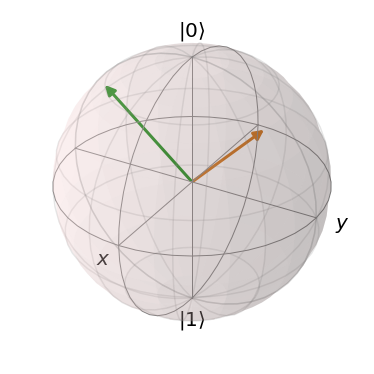

0.38


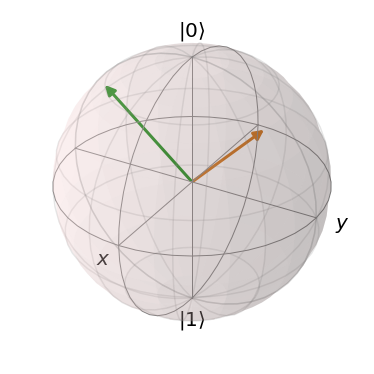

In [40]:
total = 1000
numb_yes_training = []

b = Bloch()
b.clear()
current = [np.sin(env.theta)*np.cos(env.phi), np.sin(env.theta)*np.sin(env.phi), np.cos(env.theta)]
final = [np.sin(theta2)*np.cos(phi2), np.sin(theta2)*np.sin(phi2), np.cos(theta2)]
vec = [current, final]
b.add_vectors(vec)
b.show()

while total >= 0:  
  env.reset()

  Done = False
  counter = 0
  re = 0
 
  while not Done:
    counter += 1
    s = env.state
    #print(env.qubit)
    action = select_action(s, 0)
    st, r, Done, info = env.step(action)
    #print(env.qubit)
    #print(action)
    #re += r
    
  total -= 1
  
  numb_yes_training.append(counter)

success = 0
for i in numb_yes_training:
  if i <=3:
    success += 1

print(success / 1000)
